In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install tensorflow
!pip install openpyxl
!pip install scikit-learn==1.5.2 scikeras==0.13.0

In [3]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from sklearn.neural_network import MLPRegressor

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Parametreler
start_date = "2018-01-01"
end_date = "2018-12-31"

# Tahmin periyotları - 3 farklı senaryo
TAHMIN_PERIYOTLARI = {
 '1_gun': 1,    # 03 Aralık 2018 (1 iş günü)
 '10_gun': 10,  # 03-14 Aralık 2018 (10 iş günü = 2 hafta)
 '21_gun': 21   # 03-31 Aralık 2018 (21 iş günü = 1 ay)
}

# Şu an için varsayılan değer (döngüde değişecek)
# Aktif periyot seçimi - değiştirmek için '1_gun', '10_gun' veya '21_gun' yazın
AKTIF_PERIYOT = '21_gun'
tahminEdilecekGunSayisi = TAHMIN_PERIYOTLARI[AKTIF_PERIYOT]
time_step = 30 # time_step >= tahminEdilecekGunSayisi olmalı
epoch_sayisi = 100

# CSV dosyası yolu
DATA_FILE = "/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv"

plt.style.use("fivethirtyeight")

In [4]:
# CSV'den veri okuma
print(f" Veri yükleniyor: {DATA_FILE}")

df_raw = pd.read_csv(DATA_FILE)

# Veri temizleme
df = df_raw.copy()

# Sütun adını düzelt (Now -> Close)
df = df.rename(columns={'Now': 'Close'})

# Tarih formatını düzelt (31.12.2018 -> 2018-12-31)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Sayı formatlarını düzelt (Türkçe format: virgül -> nokta)
numeric_cols = ['Close', 'Open', 'High', 'Low']
for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('.', '', regex=False) # Binlik ayracı kaldır
        df[col] = df[col].str.replace(',', '.', regex=False) # Virgülü noktaya çevir
        df[col] = df[col].astype(float)

# Sıralamayı düzelt (eskiden yeniye)
df = df.sort_values('Date').reset_index(drop=True)

# Index olarak tarih ata
df = df.set_index('Date')

# Tarih filtreleme
df = df[(df.index >= start_date) & (df.index <= end_date)]

print(f" Toplam veri: {len(df)} iş günü")
print(f" Tarih aralığı: {df.index[0].strftime('%Y-%m-%d')} → {df.index[-1].strftime('%Y-%m-%d')}")
df.head()

 Veri yükleniyor: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv
 Toplam veri: 250 iş günü
 Tarih aralığı: 2018-01-02 → 2018-12-31


,Close,Open,High,Low,Volume,Diff %
Date,,,,,,
2018-01-02,1128.88,1110.80,1130.61,1110.05,"856,59M","1,99%"
2018-01-03,1112.95,1130.94,1137.27,1110.44,"1,02B","-1,41%"
2018-01-04,1105.85,1113.22,1124.65,1102.61,"1,02B","-0,64%"
2018-01-05,1116.55,1112.34,1122.29,1109.74,"794,28M","0,97%"
2018-01-08,1112.16,1125.10,1127.52,1111.59,"806,07M","-0,39%"


In [5]:
# Sadece Kapanış değerlerinin olduğu bir dataframe oluştur
df1 = df[['Close']]
df1.head()

,Close
Date,
2018-01-02,1128.88
2018-01-03,1112.95
2018-01-04,1105.85
2018-01-05,1116.55
2018-01-08,1112.16


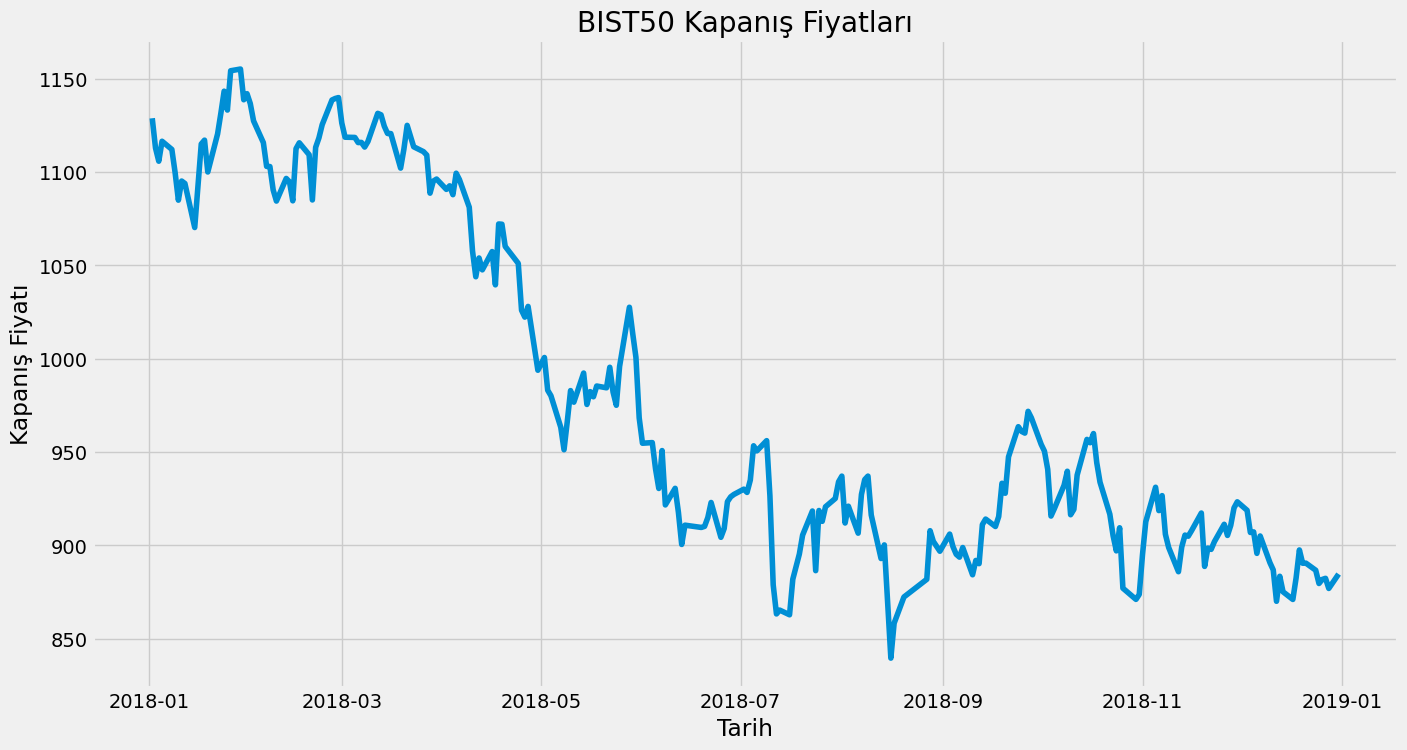

In [6]:
# Grafiği çizme
plt.figure(figsize=(15, 8))
plt.plot(df1, label="Kapanış")
plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.show()

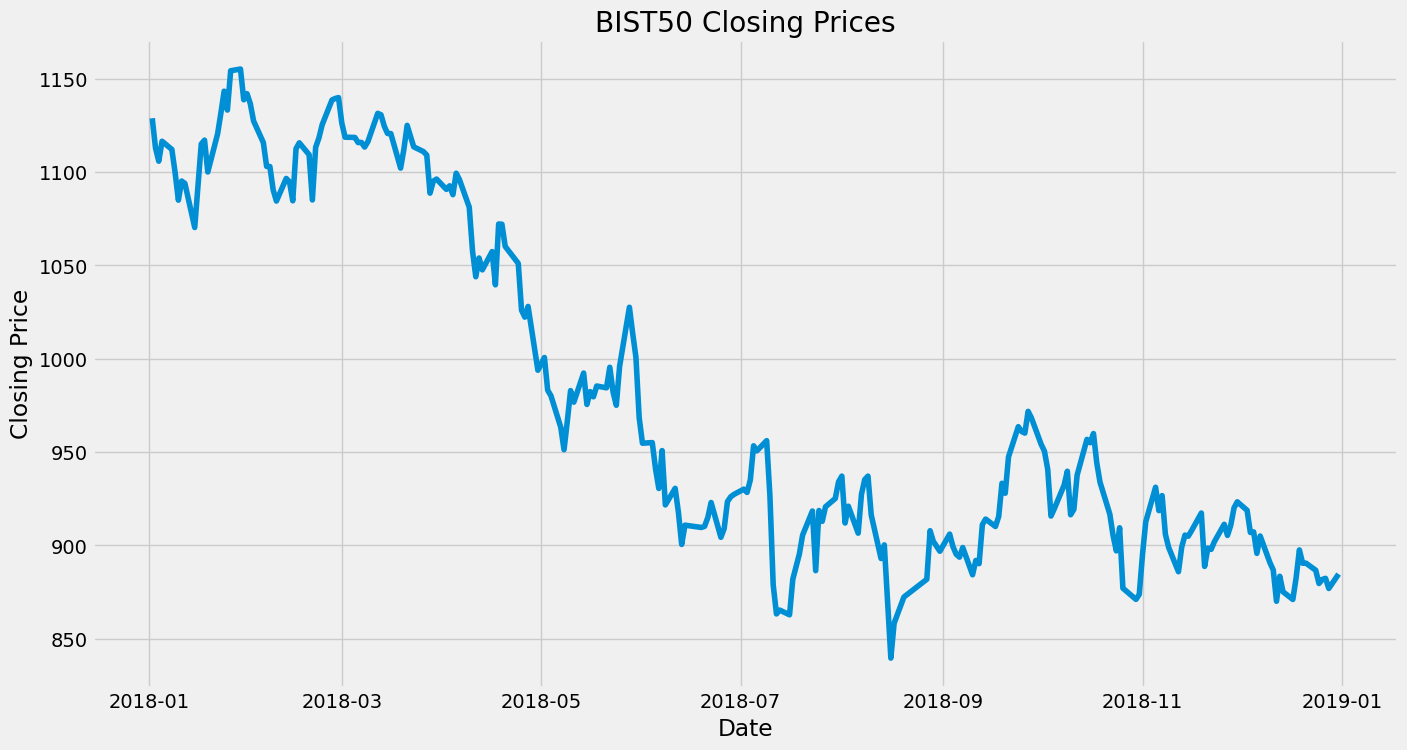

In [7]:
# Grafiği çizme (İngilizce)
plt.figure(figsize=(15, 8))
plt.plot(df1, label="Close")
plt.title("BIST50 Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [8]:
# Veriyi ayırma
train = df1[:-(time_step+2)]
test = df1[-(time_step+2):]

# Veriyi ölçekleme
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
train.tail()

,Close
Date,
2018-11-09,898.91
2018-11-12,885.90
2018-11-13,899.13
2018-11-14,905.53
2018-11-15,904.93


In [10]:
test

,Close
Date,
2018-11-16,907.86
2018-11-19,917.34
2018-11-20,888.73
2018-11-21,898.57
2018-11-22,897.87
2018-11-23,902.01
2018-11-26,911.32
2018-11-27,905.35
2018-11-28,910.73


In [11]:
# Dataset oluşturma
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(scaled_test, time_step)

In [12]:
X_train

array([[0.91648714, 0.86601825, 0.84352427, ..., 0.79486123, 0.77588392,
        0.81428209],
       [0.86601825, 0.84352427, 0.87742365, ..., 0.77588392, 0.81428209,
        0.80848435],
       [0.84352427, 0.87742365, 0.8635154 , ..., 0.81428209, 0.80848435,
        0.7762641 ],
       ...,
       [0.40786973, 0.36278672, 0.35125459, ..., 0.27588392, 0.21030288,
        0.18790394],
       [0.36278672, 0.35125459, 0.32042834, ..., 0.21030288, 0.18790394,
        0.1466861 ],
       [0.35125459, 0.32042834, 0.24116082, ..., 0.18790394, 0.1466861 ,
        0.18860094]])

In [13]:
y_train

array([0.80848435, 0.7762641 , 0.86484603, 0.87476239, 0.85458117,
       0.77778482, 0.86706374, 0.88299962, 0.9054936 , 0.94744012,
       0.95003802, 0.95155874, 0.90840831, 0.88429857, 0.88388671,
       0.87514257, 0.87545938, 0.86757065, 0.8769801 , 0.92478773,
       0.92231656, 0.90299075, 0.89060322, 0.89041313, 0.83180205,
       0.86389558, 0.90438474, 0.88619947, 0.86801419, 0.85974528,
       0.85391585, 0.78928526, 0.80975162, 0.8132366 , 0.79568496,
       0.80176784, 0.78671905, 0.82315296, 0.81231783, 0.76546065,
       0.69107211, 0.64738309, 0.67925485, 0.65913699, 0.69015334,
       0.63369662, 0.73701052, 0.73653529, 0.69889748, 0.67003548,
       0.59057787, 0.57888734, 0.59704093, 0.48868965, 0.51032822,
       0.45479027, 0.44534913, 0.3918388 , 0.35375745, 0.40200862,
       0.45415663, 0.43448232, 0.4839374 , 0.43061716, 0.45244582,
       0.44363832, 0.46191864, 0.4588772 , 0.49375871, 0.45171715,
       0.42922317, 0.49521607, 0.59564694, 0.55167279, 0.51064

In [14]:
X_test

array([[0.21625903, 0.24629325, 0.15565201, 0.18682676, 0.18460905,
        0.19772526, 0.22722088, 0.20830693, 0.22535167, 0.2550057 ,
        0.26533392, 0.25095045, 0.21331263, 0.21432645, 0.17782917,
        0.2073248 , 0.16186161, 0.14972754, 0.09647066, 0.13895577,
        0.11259663, 0.09960715, 0.13619947, 0.1836586 , 0.16110125,
        0.16122798, 0.14918895, 0.12669497, 0.13356989, 0.13547079]])

In [15]:
y_test

array([0.11826765])

In [16]:
# Veriyi yeniden şekillendirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
X_test

array([[[0.21625903],
        [0.24629325],
        [0.15565201],
        [0.18682676],
        [0.18460905],
        [0.19772526],
        [0.22722088],
        [0.20830693],
        [0.22535167],
        [0.2550057 ],
        [0.26533392],
        [0.25095045],
        [0.21331263],
        [0.21432645],
        [0.17782917],
        [0.2073248 ],
        [0.16186161],
        [0.14972754],
        [0.09647066],
        [0.13895577],
        [0.11259663],
        [0.09960715],
        [0.13619947],
        [0.1836586 ],
        [0.16110125],
        [0.16122798],
        [0.14918895],
        [0.12669497],
        [0.13356989],
        [0.13547079]]])

In [18]:
X_train

array([[[0.91648714],
        [0.86601825],
        [0.84352427],
        ...,
        [0.79486123],
        [0.77588392],
        [0.81428209]],

       [[0.86601825],
        [0.84352427],
        [0.87742365],
        ...,
        [0.77588392],
        [0.81428209],
        [0.80848435]],

       [[0.84352427],
        [0.87742365],
        [0.8635154 ],
        ...,
        [0.81428209],
        [0.80848435],
        [0.7762641 ]],

       ...,

       [[0.40786973],
        [0.36278672],
        [0.35125459],
        ...,
        [0.27588392],
        [0.21030288],
        [0.18790394]],

       [[0.36278672],
        [0.35125459],
        [0.32042834],
        ...,
        [0.21030288],
        [0.18790394],
        [0.1466861 ]],

       [[0.35125459],
        [0.32042834],
        [0.24116082],
        ...,
        [0.18790394],
        [0.1466861 ],
        [0.18860094]]])

In [19]:
#Cross Validation - DROPOUT EKLENMİŞ VERSİYON
!pip install scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Hiperparametreler
DROPOUT_RATE = 0.2
LSTM_UNITS = 50
RNN_UNITS = 50
CNN_FILTERS = 64
DENSE_UNITS = 50
MLP_UNITS = 100

# LSTM Modeli (Dropout ile)
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape),
        Dropout(DROPOUT_RATE),
        LSTM(LSTM_UNITS, return_sequences=True),
        Dropout(DROPOUT_RATE),
        LSTM(LSTM_UNITS),
        Dropout(DROPOUT_RATE),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# RNN Modeli (Dropout ile)
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(RNN_UNITS, return_sequences=True, input_shape=input_shape),
        Dropout(DROPOUT_RATE),
        SimpleRNN(RNN_UNITS, return_sequences=True),
        Dropout(DROPOUT_RATE),
        SimpleRNN(RNN_UNITS),
        Dropout(DROPOUT_RATE),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# CNN Modeli (Dropout ile)
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=CNN_FILTERS, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(DROPOUT_RATE),
        Flatten(),
        Dense(DENSE_UNITS, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# MLP Modeli (Dropout ile)
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(MLP_UNITS, activation='relu', input_dim=input_shape[0]),
        Dropout(DROPOUT_RATE),
        Dense(DENSE_UNITS, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Cross-validation için RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
kfold = KFold(n_splits=5, shuffle=False)

print('✓ Model tanımları yüklendi (Dropout=0.2 eklenmiş)')

✓ Model tanımları yüklendi (Dropout=0.2 eklenmiş)


In [20]:
# Modelleri oluştur ve eğit
# LSTM Modeli
model_lstm = Sequential([
 LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
 LSTM(50, return_sequences=True),
 LSTM(50),
 Dense(1)
])
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=epoch_sayisi, batch_size=64, verbose=1)

# RNN Modeli
model_rnn = Sequential([
 SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
 SimpleRNN(50, return_sequences=True),
 SimpleRNN(50),
 Dense(1)
])
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(X_train, y_train, epochs=epoch_sayisi, batch_size=64, verbose=1)


# CNN Modeli
model_cnn = Sequential([
 Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)), # kernel_size = 2
 MaxPooling1D(pool_size=2),
 Flatten(),
 Dense(50, activation='relu'),
 Dense(1)
])

model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.fit(X_train, y_train, epochs=epoch_sayisi, batch_size=64, verbose=1)


# MLP Modeli
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=epoch_sayisi)
model_mlp.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2176
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0661
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0296
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0437
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0155
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0272
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0256
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0159
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0151
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0173
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0119
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0135
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0113
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098
Epoch 16/100
3/3 ━━

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - loss: 0.1445
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0268
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0412
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0132
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0115
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099
Epoch 16/100
3/3 ━━━━━━━━━━━━━

MLPRegressor(max_iter=100)

In [21]:
df1

,Close
Date,
2018-01-02,1128.88
2018-01-03,1112.95
2018-01-04,1105.85
2018-01-05,1116.55
2018-01-08,1112.16
...,...
2018-12-25,879.59
2018-12-26,881.76
2018-12-27,882.36


In [22]:
scaled_df1 = scaler.transform(df1)

def make_predictions(model, is_mlp=False):
    X, y = create_dataset(scaled_df1, time_step)
    if is_mlp:
        X_predict = model.predict(X[-tahminEdilecekGunSayisi:, :])
    else:
        X_3D = X.reshape(X.shape[0], X.shape[1], 1)
        X_predict = model.predict(X_3D[-tahminEdilecekGunSayisi:, :])
    return scaler.inverse_transform(X_predict.reshape(-1, 1))

# Tahminleri al
lstm_predictions = make_predictions(model_lstm)
rnn_predictions = make_predictions(model_rnn)
cnn_predictions = make_predictions(model_cnn)
mlp_predictions = make_predictions(model_mlp, is_mlp=True)


# Performans ölçütleri
def calculate_metrics(true_values, predictions):
    rmse = math.sqrt(mean_squared_error(true_values, predictions))
    relative_rmse = rmse / np.mean(true_values)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    return rmse, relative_rmse, mape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [23]:
lstm_predictions

array([[909.11993],
       [910.2901 ],
       [911.5897 ],
       [912.5194 ],
       [912.9866 ],
       [912.74176],
       [912.1577 ],
       [911.12695],
       [909.6686 ],
       [907.55493],
       [905.35376],
       [903.1585 ],
       [901.0153 ],
       [899.3528 ],
       [898.5758 ],
       [898.47406],
       [898.7996 ],
       [899.26166],
       [899.50543],
       [899.53516],
       [899.41315]], dtype=float32)

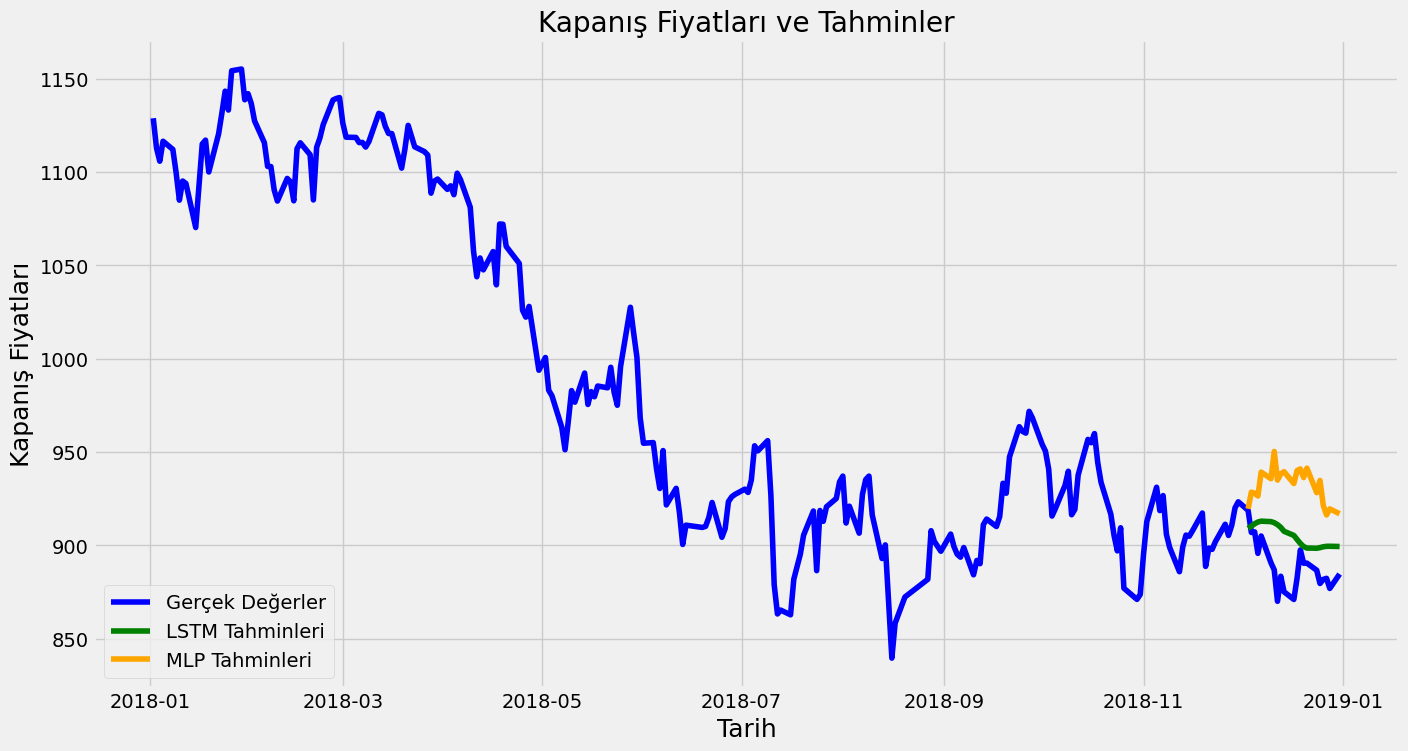

In [24]:
# Tahminler için doğru tarih aralığını al
tahmin_tarihleri = df.index[-tahminEdilecekGunSayisi:]

# Grafik çizme
plt.figure(figsize=(15, 8))
plt.title('Kapanış Fiyatları ve Tahminler')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatları', fontsize=18)

#plt.plot(train.index, train['Close'], label='Train', color='blue')
#plt.plot(test.index, test['Close'], label='Test', color='green')

#plt.plot(df.index[:-(tahminEdilecekGunSayisi-1)], df[:-(tahminEdilecekGunSayisi-1)]['Close'], label='Train (Gerçek)', color='blue')
#plt.plot(df.index[-tahminEdilecekGunSayisi:], df[-tahminEdilecekGunSayisi:]['Close'], label='Test (Gerçek)', color='green')
plt.plot(df.index[:], df[:]['Close'], label='Gerçek Değerler', color='blue')


plt.plot(tahmin_tarihleri, lstm_predictions, label='LSTM Tahminleri',color='green')
plt.plot(tahmin_tarihleri, mlp_predictions, label='MLP Tahminleri', color='orange')
#plt.plot(tahmin_tarihleri, rnn_predictions, label='RNN Tahminleri')
#plt.plot(tahmin_tarihleri, cnn_predictions, label='CNN Tahminleri')

plt.legend(loc='lower left')
plt.show()

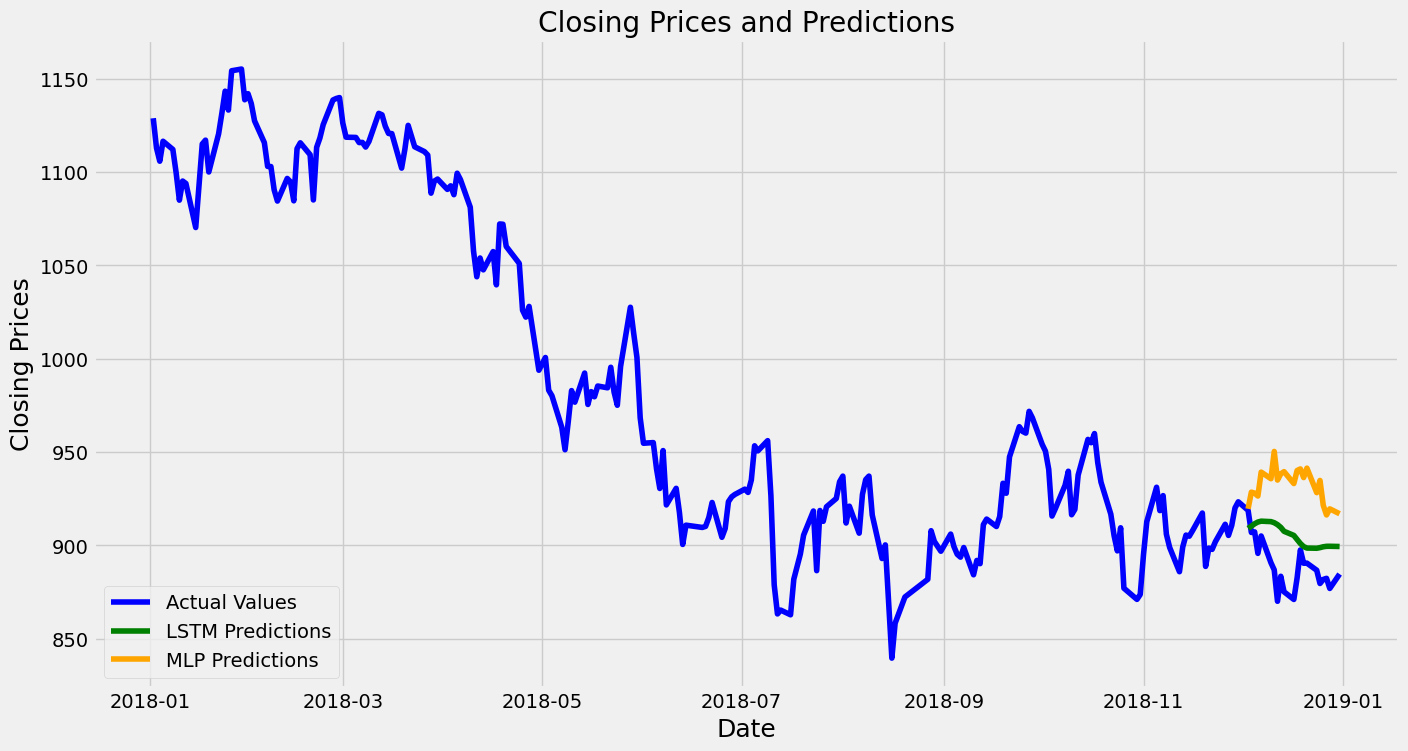

In [25]:
# Tahminler için doğru tarih aralığını al (İngilizce)
tahmin_tarihleri = df.index[-tahminEdilecekGunSayisi:]

# Grafik çizme
plt.figure(figsize=(15, 8))
plt.title('Closing Prices and Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Prices', fontsize=18)

#plt.plot(train.index, train['Close'], label='Train', color='blue')
#plt.plot(test.index, test['Close'], label='Test', color='green')

#plt.plot(df.index[:-(tahminEdilecekGunSayisi-1)], df[:-(tahminEdilecekGunSayisi-1)]['Close'], label='Train (Gerçek)', color='blue')
#plt.plot(df.index[-tahminEdilecekGunSayisi:], df[-tahminEdilecekGunSayisi:]['Close'], label='Test (Gerçek)', color='green')
plt.plot(df.index[:], df[:]['Close'], label='Actual Values', color='blue')


plt.plot(tahmin_tarihleri, lstm_predictions, label='LSTM Predictions',color='green')
plt.plot(tahmin_tarihleri, mlp_predictions, label='MLP Predictions', color='orange')
#plt.plot(tahmin_tarihleri, rnn_predictions, label='RNN Tahminleri')
#plt.plot(tahmin_tarihleri, cnn_predictions, label='CNN Tahminleri')

plt.legend(loc='lower left')
plt.show()

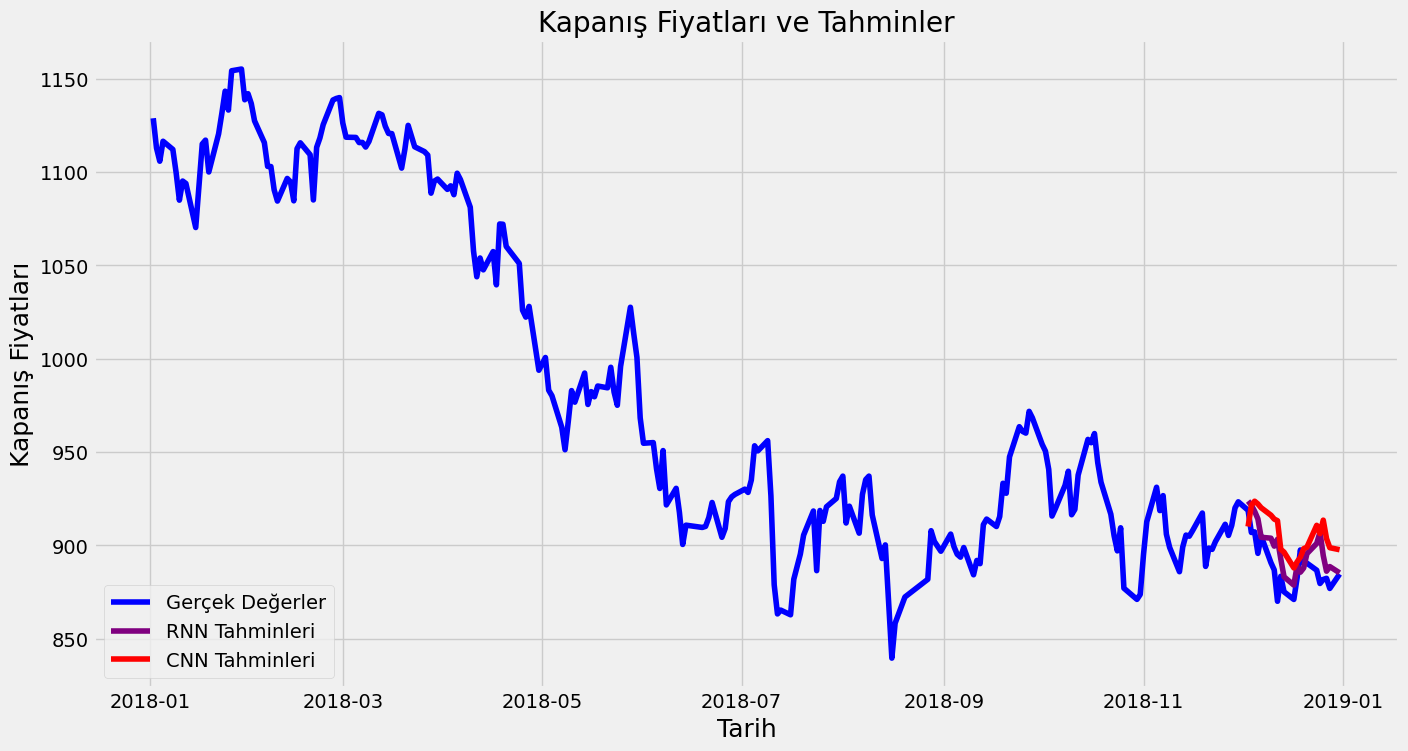

In [26]:
# Tahminler için doğru tarih aralığını al
tahmin_tarihleri = df.index[-tahminEdilecekGunSayisi:]

# Grafik çizme
plt.figure(figsize=(15, 8))
plt.title('Kapanış Fiyatları ve Tahminler')
plt.xlabel('Tarih', fontsize=18)
plt.ylabel('Kapanış Fiyatları', fontsize=18)

#plt.plot(train.index, train['Close'], label='Train', color='blue')
#plt.plot(test.index, test['Close'], label='Test', color='green')

#plt.plot(df.index[:-(tahminEdilecekGunSayisi-1)], df[:-(tahminEdilecekGunSayisi-1)]['Close'], label='Train (Gerçek)', color='blue')
#plt.plot(df.index[-tahminEdilecekGunSayisi:], df[-tahminEdilecekGunSayisi:]['Close'], label='Test (Gerçek)', color='green')
plt.plot(df.index[:], df[:]['Close'], label='Gerçek Değerler', color='blue')


#plt.plot(tahmin_tarihleri, lstm_predictions, label='LSTM Tahminleri')
#plt.plot(tahmin_tarihleri, mlp_predictions, label='MLP Tahminleri')
plt.plot(tahmin_tarihleri, rnn_predictions, label='RNN Tahminleri', color='purple')
plt.plot(tahmin_tarihleri, cnn_predictions, label='CNN Tahminleri', color='red')

plt.legend(loc='lower left')
plt.show()

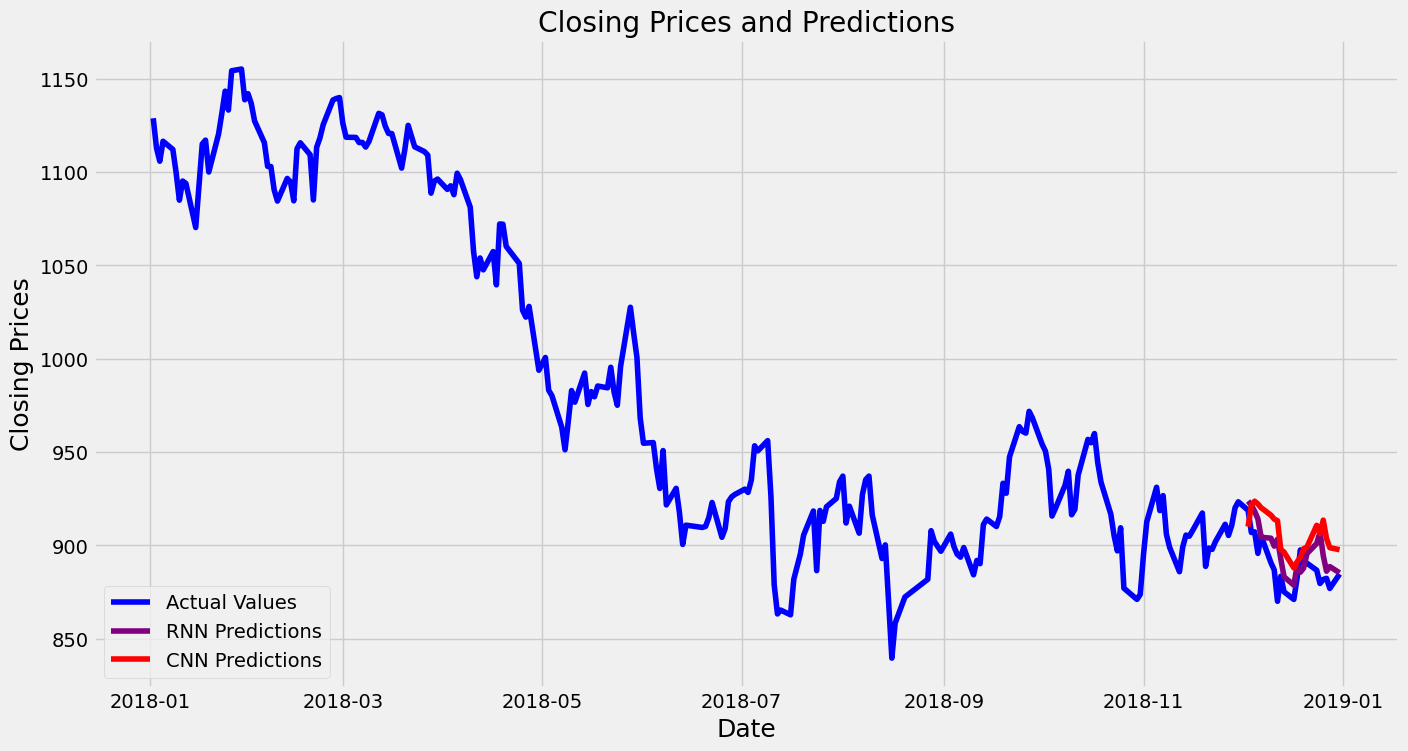

In [27]:
# Tahminler için doğru tarih aralığını al (İngilizce)
tahmin_tarihleri = df.index[-tahminEdilecekGunSayisi:]

# Grafik çizme
plt.figure(figsize=(15, 8))
plt.title('Closing Prices and Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Prices', fontsize=18)

#plt.plot(train.index, train['Close'], label='Train', color='blue')
#plt.plot(test.index, test['Close'], label='Test', color='green')

#plt.plot(df.index[:-(tahminEdilecekGunSayisi-1)], df[:-(tahminEdilecekGunSayisi-1)]['Close'], label='Train (Gerçek)', color='blue')
#plt.plot(df.index[-tahminEdilecekGunSayisi:], df[-tahminEdilecekGunSayisi:]['Close'], label='Test (Gerçek)', color='green')
plt.plot(df.index[:], df[:]['Close'], label='Actual Values', color='blue')


#plt.plot(tahmin_tarihleri, lstm_predictions, label='LSTM Tahminleri')
#plt.plot(tahmin_tarihleri, mlp_predictions, label='MLP Tahminleri')
plt.plot(tahmin_tarihleri, rnn_predictions, label='RNN Predictions', color='purple')
plt.plot(tahmin_tarihleri, cnn_predictions, label='CNN Predictions', color='red')

plt.legend(loc='lower left')
plt.show()

In [28]:
# Performans ölçütlerini hesaplama
performance_metrics = []

true_values = df1[-tahminEdilecekGunSayisi:].values

for model_name, preds in zip(["LSTM", "RNN", "CNN", "MLP"], [lstm_predictions, rnn_predictions, cnn_predictions, mlp_predictions]):
 mse = mean_squared_error(true_values, preds)
 mae = mean_absolute_error(true_values, preds)
 #mape = np.mean(np.abs((true_values - preds) / true_values)) * 100
 mape = mean_absolute_percentage_error(true_values, preds)
 r2 = r2_score(true_values, preds)
 rmse = np.sqrt(mse)
 relative_rmse = rmse / np.mean(true_values)

 performance_metrics.append({
 "Model": model_name,
 "RMSE": rmse,
 "Relative RMSE": relative_rmse,
 "MAE": mae,
 "MAPE": mape,
 "R2": r2
 })

# Performans ölçütlerini DataFrame'e çevirme
performance_df = pd.DataFrame(performance_metrics)

# "Model" sütununun yazı tipini sola dayalı yapma
performance_df = performance_df.rename(columns={'Model': ' Model'})

# Performans ölçütlerini RMSE'ye göre sıralama (düşükten yükseğe)
sorted_performance_df = performance_df.sort_values(by='RMSE')

# Sıralı performans ölçütlerini yazdırma
sorted_performance_df_formatted = sorted_performance_df.to_string(index=False, formatters={'Model': '{:<5}'.format})
print(sorted_performance_df_formatted)


 Model      RMSE  Relative RMSE       MAE     MAPE         R2
   RNN 13.540081       0.015235 10.994424 0.012410  -0.191824
  LSTM 20.253559       0.022788 17.500050 0.019821  -1.666689
   CNN 21.058495       0.023694 18.919571 0.021362  -1.882865
   MLP 46.067084       0.051833 43.146760 0.048764 -12.795932


In [29]:
# Veriyi Excel dosyasına kaydedin
#excel_file_name = f'/content/drive/MyDrive/Colab Notebooks/tez/DerinOgrenme_BorsaSonuclari_{start_date}_{end_date}_tahminEdilecekGunSayisi_{tahminEdilecekGunSayisi}.xlsx'
#sorted_performance_df.to_excel(excel_file_name, index=False)

In [30]:
# =============================================================================
# TÜM PERİYOTLAR İÇİN TEST (1 gün, 10 gün, 21 gün)
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import os

# Sonuç dizini
SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/1_DeepLearning'
os.makedirs(SONUC_DIZINI, exist_ok=True)

# Notebook bilgileri
NOTEBOOK_ADI = "1_DeepLearning"
VERI_TIPI = "az_veri"
KATEGORI = "Deep Learning"

print("=" * 80)
print(f" {NOTEBOOK_ADI} - TÜM PERİYOTLAR İÇİN TEST")
print(f" Veri Tipi: {VERI_TIPI.upper()}")
print("=" * 80)

# Tüm sonuçları toplayacak liste
tum_sonuclar = []

# Her periyot için test yap
for periyot_adi, gun_sayisi in TAHMIN_PERIYOTLARI.items():
    print(f"\n{'='*60}")
    print(f" {periyot_adi} ({gun_sayisi} iş günü) test ediliyor...")
    print('='*60)

    # Bu periyot için tahminleri al
    tahmin_gun = gun_sayisi

    # Gerçek değerler
    true_vals = df1[-tahmin_gun:].values.flatten()

    # Her model için tahmin ve metrik hesapla
    for model_name, model, is_mlp in [("LSTM", model_lstm, False),
                                        ("RNN", model_rnn, False),
                                        ("CNN", model_cnn, False),
                                        ("MLP", model_mlp, True)]:
        try:
            # Tahmin yap
            X, y = create_dataset(scaled_df1, time_step)
            if is_mlp:
                preds = model.predict(X[-tahmin_gun:, :])
            else:
                X_3D = X.reshape(X.shape[0], X.shape[1], 1)
                preds = model.predict(X_3D[-tahmin_gun:, :], verbose=0)

            # Ters ölçekleme
            preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()

            # Boyut kontrolü
            min_len = min(len(true_vals), len(preds))
            true_v = true_vals[:min_len]
            pred_v = preds[:min_len]

            # Metrikler
            rmse = np.sqrt(mean_squared_error(true_v, pred_v))
            mae = mean_absolute_error(true_v, pred_v)
            r2 = r2_score(true_v, pred_v)
            mape = mean_absolute_percentage_error(true_v, pred_v) * 100

            tum_sonuclar.append({
                'Model': model_name,
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': gun_sayisi,
                'RMSE': round(rmse, 4),
                'MAE': round(mae, 4),
                'R2': round(r2, 4),
                'MAPE': round(mape, 2)
            })

            print(f"  ✓ {model_name}: RMSE={rmse:.4f}, R²={r2:.4f}")

        except Exception as e:
            print(f"  ✗ {model_name}: Hata - {e}")
            tum_sonuclar.append({
                'Model': model_name,
                'Kategori': KATEGORI,
                'Veri_Tipi': VERI_TIPI,
                'Periyot': periyot_adi,
                'Periyot_Gun': gun_sayisi,
                'RMSE': np.nan,
                'MAE': np.nan,
                'R2': np.nan,
                'MAPE': np.nan
            })

# DataFrame oluştur
sonuc_df = pd.DataFrame(tum_sonuclar)

print("\n" + "=" * 80)
print(" TÜM SONUÇLAR")
print("=" * 80)


 1_DeepLearning - TÜM PERİYOTLAR İÇİN TEST
 Veri Tipi: AZ_VERI

 1_gun (1 iş günü) test ediliyor...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  ✓ LSTM: RMSE=14.7609, R²=nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  ✓ RNN: RMSE=0.6225, R²=nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  ✓ CNN: RMSE=13.0399, R²=nan
  ✓ MLP: RMSE=32.3055, R²=nan

 10_gun (10 iş günü) test ediliyor...
  ✓ LSTM: RMSE=15.5426, R²=-6.1567
  ✓ RNN: RMSE=12.2224, R²=-3.4257
  ✓ CNN: RMSE=19.0371, R²=-9.7367
  ✓ MLP: RMSE=45.0116, R²=-59.0229

 21_gun (21 iş günü) test ediliyor...
  ✓ LSTM: RMSE=20.2536, R²=-1.6667
  ✓ RNN: RMSE=13.5401, R²=-0.1918
  ✓ CNN: RMSE=21.0585, R²=-1.8829
  ✓ MLP: RMSE=46.0671, R²=-12.7959

 TÜM SONUÇLAR


In [31]:
# =============================================================================
# SONUÇ TABLOSU - PERİYOTLARA GÖRE
# =============================================================================

# Pivot tablo oluştur (Model × Periyot)
print("\n" + "=" * 80)
print(" SONUÇ TABLOSU - RMSE")
print("=" * 80)

pivot_rmse = sonuc_df.pivot(index='Model', columns='Periyot', values='RMSE')
pivot_rmse = pivot_rmse[['1_gun', '10_gun', '21_gun']]  # Sıralama
print(pivot_rmse.to_string())

print("\n" + "=" * 80)
print(" SONUÇ TABLOSU - R²")
print("=" * 80)

pivot_r2 = sonuc_df.pivot(index='Model', columns='Periyot', values='R2')
pivot_r2 = pivot_r2[['1_gun', '10_gun', '21_gun']]
print(pivot_r2.to_string())

print("\n" + "=" * 80)
print(" SONUÇ TABLOSU - MAE")
print("=" * 80)

pivot_mae = sonuc_df.pivot(index='Model', columns='Periyot', values='MAE')
pivot_mae = pivot_mae[['1_gun', '10_gun', '21_gun']]
print(pivot_mae.to_string())

print("\n" + "=" * 80)
print(" SONUÇ TABLOSU - MAPE (%)")
print("=" * 80)

pivot_mape = sonuc_df.pivot(index='Model', columns='Periyot', values='MAPE')
pivot_mape = pivot_mape[['1_gun', '10_gun', '21_gun']]
print(pivot_mape.to_string())

# En iyi modeller
print("\n" + "=" * 80)
print(" EN İYİ MODELLER (RMSE bazında)")
print("=" * 80)
for periyot in ['1_gun', '10_gun', '21_gun']:
    subset = sonuc_df[sonuc_df['Periyot'] == periyot]
    if len(subset) > 0:
        best = subset.loc[subset['RMSE'].idxmin()]
        print(f"  {periyot:8} → {best['Model']:6} (RMSE: {best['RMSE']:.4f}, R²: {best['R2']:.4f})")



 SONUÇ TABLOSU - RMSE
Periyot    1_gun   10_gun   21_gun
Model                             
CNN      13.0399  19.0371  21.0585
LSTM     14.7609  15.5426  20.2536
MLP      32.3055  45.0116  46.0671
RNN       0.6225  12.2224  13.5401

 SONUÇ TABLOSU - R²
Periyot  1_gun   10_gun   21_gun
Model                           
CNN        NaN  -9.7367  -1.8829
LSTM       NaN  -6.1567  -1.6667
MLP        NaN -59.0229 -12.7959
RNN        NaN  -3.4257  -0.1918

 SONUÇ TABLOSU - MAE
Periyot    1_gun   10_gun   21_gun
Model                             
CNN      13.0399  16.7547  18.9196
LSTM     14.7609  14.3978  17.5001
MLP      32.3055  44.3142  43.1468
RNN       0.6225   9.6860  10.9944

 SONUÇ TABLOSU - MAPE (%)
Periyot  1_gun  10_gun  21_gun
Model                         
CNN       1.47    1.90    2.14
LSTM      1.67    1.63    1.98
MLP       3.65    5.01    4.88
RNN       0.07    1.10    1.24

 EN İYİ MODELLER (RMSE bazında)
  1_gun    → RNN    (RMSE: 0.6225, R²: nan)
  10_gun   → RNN    (RMSE:

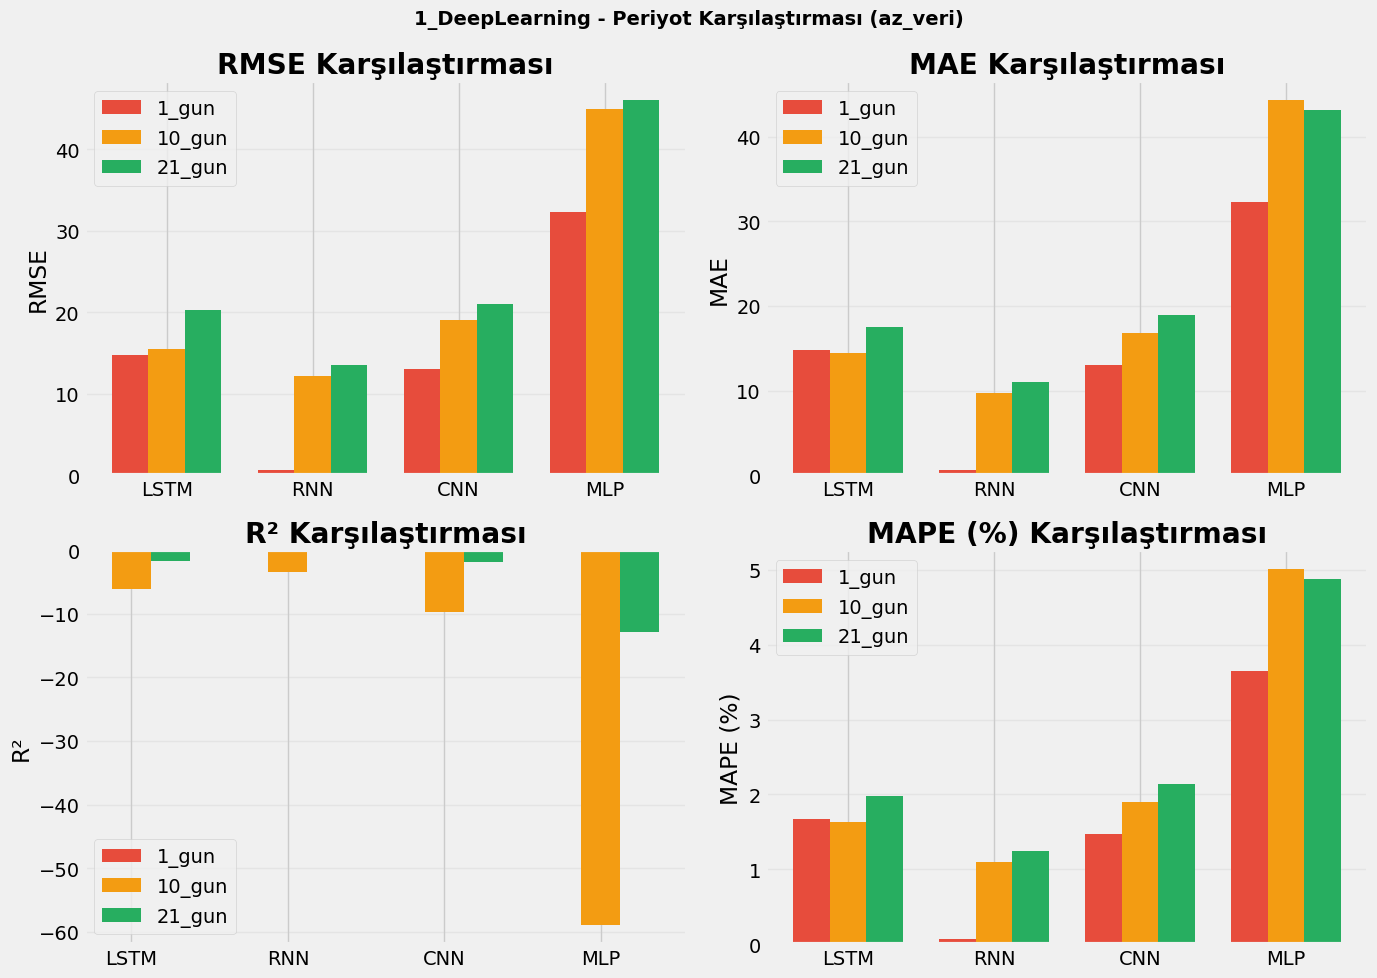


📈 Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/1_DeepLearning/1_DeepLearning_karsilastirma.png


In [32]:
# =============================================================================
# KARŞILAŞTIRMA GRAFİKLERİ
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'{NOTEBOOK_ADI} - Periyot Karşılaştırması ({VERI_TIPI})', fontsize=14, fontweight='bold')

models = ['LSTM', 'RNN', 'CNN', 'MLP']
periyotlar = ['1_gun', '10_gun', '21_gun']
x = np.arange(len(models))
width = 0.25
colors = ['#e74c3c', '#f39c12', '#27ae60']  # 1 gün, 10 gün, 21 gün

# 1. RMSE Karşılaştırması
ax1 = axes[0, 0]
for i, periyot in enumerate(periyotlar):
    values = [pivot_rmse.loc[m, periyot] if m in pivot_rmse.index else 0 for m in models]
    bars = ax1.bar(x + i*width, values, width, label=periyot, color=colors[i])
ax1.set_title('RMSE Karşılaştırması', fontweight='bold')
ax1.set_ylabel('RMSE')
ax1.set_xticks(x + width)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. MAE Karşılaştırması
ax2 = axes[0, 1]
for i, periyot in enumerate(periyotlar):
    values = [pivot_mae.loc[m, periyot] if m in pivot_mae.index else 0 for m in models]
    bars = ax2.bar(x + i*width, values, width, label=periyot, color=colors[i])
ax2.set_title('MAE Karşılaştırması', fontweight='bold')
ax2.set_ylabel('MAE')
ax2.set_xticks(x + width)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. R² Karşılaştırması
ax3 = axes[1, 0]
for i, periyot in enumerate(periyotlar):
    values = [pivot_r2.loc[m, periyot] if m in pivot_r2.index else 0 for m in models]
    bars = ax3.bar(x + i*width, values, width, label=periyot, color=colors[i])
ax3.set_title('R² Karşılaştırması', fontweight='bold')
ax3.set_ylabel('R²')
ax3.set_xticks(x + width)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. MAPE Karşılaştırması
ax4 = axes[1, 1]
for i, periyot in enumerate(periyotlar):
    values = [pivot_mape.loc[m, periyot] if m in pivot_mape.index else 0 for m in models]
    bars = ax4.bar(x + i*width, values, width, label=periyot, color=colors[i])
ax4.set_title('MAPE (%) Karşılaştırması', fontweight='bold')
ax4.set_ylabel('MAPE (%)')
ax4.set_xticks(x + width)
ax4.set_xticklabels(models)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_karsilastirma.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 Grafik kaydedildi: {SONUC_DIZINI}/{NOTEBOOK_ADI}_karsilastirma.png")


In [33]:
# =============================================================================
# EXCEL'E KAYDET
# =============================================================================

# Tüm sonuçları tek Excel dosyasına kaydet
excel_dosya = f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_tum_sonuclar.xlsx"

with pd.ExcelWriter(excel_dosya, engine='openpyxl') as writer:
    # Ham veriler
    sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)

    # Pivot tablolar
    pivot_rmse.to_excel(writer, sheet_name='RMSE')
    pivot_mae.to_excel(writer, sheet_name='MAE')
    pivot_r2.to_excel(writer, sheet_name='R2')
    pivot_mape.to_excel(writer, sheet_name='MAPE')

print(f"\n✅ Tüm sonuçlar kaydedildi: {excel_dosya}")

# =============================================================================
# ÖZET
# =============================================================================
print("\n" + "=" * 80)
print(f" ÖZET - {NOTEBOOK_ADI}")
print("=" * 80)
print(f" Veri Tipi: {VERI_TIPI}")
print(f" Kategori: {KATEGORI}")
print(f" Test Edilen Modeller: {len(models)}")
print(f" Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun")
print(f" Toplam Test: {len(sonuc_df)}")
print("=" * 80)
print(f"\n📁 Kaydedilen dosyalar:")
print(f"   - {excel_dosya}")
print(f"   - {SONUC_DIZINI}/{NOTEBOOK_ADI}_karsilastirma.png")



✅ Tüm sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/1_DeepLearning/1_DeepLearning_tum_sonuclar.xlsx

 ÖZET - 1_DeepLearning
 Veri Tipi: az_veri
 Kategori: Deep Learning
 Test Edilen Modeller: 4
 Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun
 Toplam Test: 12

📁 Kaydedilen dosyalar:
   - /content/drive/MyDrive/Colab Notebooks/Sonuclar/1_DeepLearning/1_DeepLearning_tum_sonuclar.xlsx
   - /content/drive/MyDrive/Colab Notebooks/Sonuclar/1_DeepLearning/1_DeepLearning_karsilastirma.png
